### Building Chatbot With Multiple Tools Using Langgraph

### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [5]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\user\AppData\Local\Temp\ipykernel_12740\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("Provide recent AI news for February 12th, 2026")

[{'title': 'AI Business and Development Daily News Rundown February 12 ...',
  'url': 'https://www.youtube.com/watch?v=uwIz_0j4jfg',
  'content': "... News Rundown February 12 2026: Musk's Moon Factory, China's New... No views · 10 minutes ago. AI Unraveled: Latest AI News & Trends, Master",
  'score': 0.99986756},
 {'title': 'Nebius Unveils Multibillion Dollar AI Factory In Birmingham',
  'url': 'https://evrimagaci.org/gpt/nebius-unveils-multibillion-dollar-ai-factory-in-birmingham-528648?srsltid=AfmBOori1Fz1_hsxsqL6FmkqBx35y0RELV4t5wY5_hyJOuiFGD2Zzhjb',
  'content': '6 min read\n\n## Key Points\n\nOn February 12, 2026, Nebius, a rising star in the artificial intelligence infrastructure world, announced plans to build a colossal AI factory in Birmingham. The move, which represents a multibillion-dollar investment, signals both the company’s growing ambitions and Birmingham’s emergence as a new hub for advanced technology. In a candid discussion with the Birmingham Business Journal, a 

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [12]:
### Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is the recent AI News". Likely they want a summary of recent AI news. Need up-to-date info. Use search tool to get recent AI news. Use tavily_search_results_json for current events.', 'tool_calls': [{'id': 'fc_3b74d493-e57d-4831-9c66-885c790afcd5', 'function': {'arguments': '{"query":"latest AI news 2024 February"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 291, 'total_tokens': 377, 'completion_time': 0.179716322, 'completion_tokens_details': {'reasoning_tokens': 49}, 'prompt_time': 0.012627037, 'prompt_tokens_details': None, 'queue_time': 0.017798884, 'total_time': 0.192343359}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_dddd02f37b', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c5347-40b0-7901-b00b-22cfd72e7f77-0

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news 2024'},
  'id': 'fc_9b2af449-3936-452f-949e-ce166f77b529',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

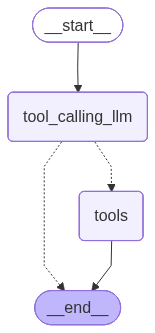

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_dea931e8-31f9-4745-9e08-be719ddfd7d3)
 Call ID: fc_dea931e8-31f9-4745-9e08-be719ddfd7d3
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [21]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for February 12th, 2026")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for February 12th, 2026
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_009cc221-d4ba-4fd4-abf1-beb58e03dff5)
 Call ID: fc_009cc221-d4ba-4fd4-abf1-beb58e03dff5
  Args:
    query: AI news February 12 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "1 Artificial Intelligence (AI) Winner Hiding in Plain Sight for 2026", "url": "https://finance.yahoo.com/news/1-artificial-intelligence-ai-winner-162000585.html", "content": "* [US](https://www.yahoo.com/news/us/). * [Health](https://health.yahoo.com/). * [Health](https://health.yahoo.com/). * [Shopping](https://shopping.yahoo.com/). + [Health](https://shopping.yahoo.com/health/). + [Tech](https://shopping.yahoo.com/tech/). * [My Portfolio](https://finance.yahoo.com/p

In [24]:
messages=graph.invoke({"messages":HumanMessage(content="Search in wikipedia what is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Search in wikipedia what is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_2232dd80-fe52-4eb1-9495-7001ba5bb176)
 Call ID: fc_2232dd80-fe52-4eb1-9495-7001ba5bb176
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
